In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
batch_size=16
learning_rate=0.0001
epoch=20

n_node=1024
dropratio=0.5

imgsize=256

In [7]:
img_dir="./drive/MyDrive/fruit/train"
train_data=dset.ImageFolder(img_dir, transforms.Compose([
            transforms.CenterCrop(imgsize*2),
            transforms.RandomCrop(imgsize),
            transforms.RandomHorizontalFlip(),
    
            transforms.Resize(imgsize),
            transforms.ToTensor()
            ]))
print(train_data.__len__())

train_batch=data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

82


In [8]:
img_dir="./drive/MyDrive/fruit/val"
dev_data=dset.ImageFolder(img_dir, transforms.Compose([
            transforms.CenterCrop(size=imgsize),
    
            transforms.Resize(imgsize),
            transforms.ToTensor()
            ]))


dev_batch=data.DataLoader(dev_data, batch_size=batch_size, shuffle=True, num_workers=2)

img_dir="./drive/MyDrive/fruit/test"
test_data=dset.ImageFolder(img_dir, transforms.Compose([
            transforms.CenterCrop(size=imgsize),
    
            transforms.Resize(imgsize),
            transforms.ToTensor()
            ]))


test_batch=data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

nclass=len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d" 
     %(train_data.__len__(), dev_data.__len__(), test_data.__len__()))

# of classes: 2
['apple', 'melon']
{'apple': 0, 'melon': 1}
82
Training: 82, Dev: 24, Test: 29


In [9]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['apple', 'melon']
['apple', 'melon']
['apple', 'melon']


# model

In [10]:
vgg=models.vgg19(pretrained=True)

for name,module in vgg.named_children():
    print(name)
    
print(list(vgg.children())[0])
print(list(vgg.children())[-1])

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU

In [11]:
print(list(vgg.children())[0][0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


# Customized fully Model


In [12]:
base_dim=64
fsize=int(imgsize/32)

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        self.layer0=nn.Sequential(*list(vgg.children())[0])
        
        self.layer1=nn.Sequential(
            nn.Linear(8*base_dim*fsize*fsize, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
        
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
        
            nn.Linear(n_node, nclass),
        )
        
        for m in self.layer1.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
                    
    def forward(self, x):
        out=self.layer0(x)
        out=out.view(out.size(0),-1)
        out=self.layer1(out)
        return out

In [13]:
model=MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad=False
    
for params in model.layer1.parameters():
    params.required_grad=True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [14]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [15]:
loss_func=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.layer1.parameters(), lr=learning_rate)

In [16]:
import utils

total_time=0
disp_step=10

to_train=True
if (to_train==False):
    netname='./drive/MyDrive/Colab Notebooks/nets/fruit_cgg19_10.pkl'
    model=torch.load(netname)
else:
    print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval()
    train_corr=utils.ComputeCorr(train_batch, model)
    dev_corr=utils.ComputeCorr(dev_batch, model)
    test_corr=utils.ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test:%2.f"
          %(train_corr, dev_corr, test_corr))
    model.train()

    netname='./drive/MyDrive/Colab Notebooks/nets/fruit_vgg19'

    x_epoch=[]
    y_train_err=[]
    y_dev_err=[]
    y_test_err=[]

    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)

    for i in range(epoch):
        start_time=time.time()
        print("%d.." %i),
        for img,label in train_batch:
            img=Variable(img).cuda()
            label=Variable(label).cuda()

            optimizer.zero_grad()
            output=model(img)
            loss=loss_func(output, label)
            loss.backward()
            optimizer.step()

        end_time=time.time()
        duration=end_time-start_time
        total_time+=duration
        if (i%disp_step==0) or (i==epoch-1):
            torch.save(model, netname+'_%d.pkl'%i, )
            print("\n[%d/%d] loss: %.3f, " %(i, epoch, (loss.cpu()). data.numpy()))

            model.eval()

            train_corr=utils.ComputeCorr(train_batch, model)
            dev_corr=utils.ComputeCorr(dev_batch, model)
            test_corr=utils.ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test:%2.f"
                  %(train_corr, dev_corr, test_corr)),
            model.train()
            print("time: %.2f sec.." %(total_time))

            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
    print("Total time: %.2f sec" %total_time)

3 layer, n_node: 1024, dropratio: 0.50
Correct of train: 32.93, dev: 41.67, test:34
0..

[0/20] loss: 1.209, 
Correct of train: 78.05, dev: 79.17, test:79
time: 2.33 sec..
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..

[10/20] loss: 0.045, 
Correct of train: 100.00, dev: 87.50, test:100
time: 24.24 sec..
11..
12..
13..
14..
15..
16..
17..
18..
19..

[19/20] loss: 1.938, 
Correct of train: 98.78, dev: 87.50, test:100
time: 44.14 sec..
Total time: 44.14 sec


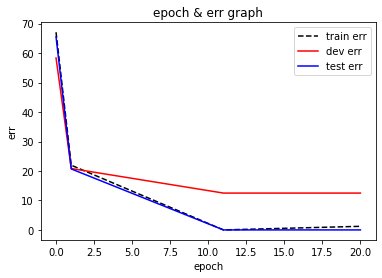

In [17]:
if (to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')

    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show()

Normalized confusion matrix


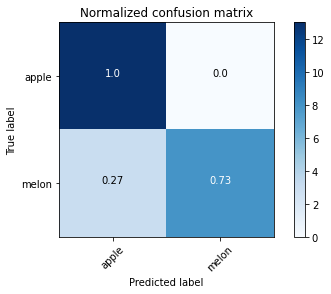

Confusion matrix, without normalization


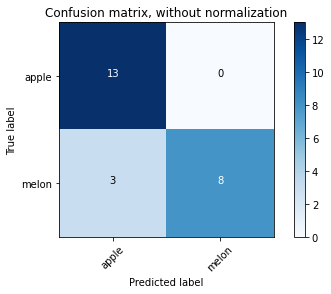

	 acc  |	 pre  |	 rec  |	 f1
 apple: 0.88 |	 0.81 |	 1.00 |	 0.90
 melon: 0.88 |	 1.00 |	 0.73 |	 0.84
*accuracy: 0.88, precision: 0.91, recall: 0.86, *f1 score: 0.87
[AP]
apple: 1.00
melon: 1.00

[mAP] 1.000
[miAP] 0.938


(array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0]),
 array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        0, 0]),
 array([0.99350053, 0.99067408, 0.99831784, 0.98453617, 0.95817763,
        0.99034101, 0.9988575 , 0.99306262, 0.99598217, 0.99973744,
        0.8154341 , 0.99974102, 0.94240105, 0.99384522, 0.99747437,
        0.69183546, 0.99892509, 0.99330616, 0.74041307, 0.99913967,
        0.82499546, 0.96242213, 0.99760085, 0.99224609]))

In [18]:
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


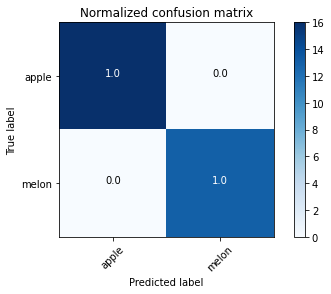

Confusion matrix, without normalization


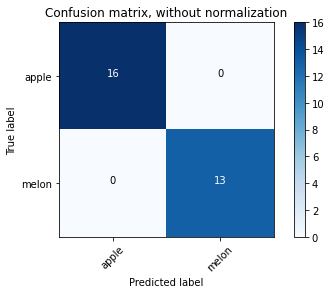

	 acc  |	 pre  |	 rec  |	 f1
 apple: 1.00 |	 1.00 |	 1.00 |	 1.00
 melon: 1.00 |	 1.00 |	 1.00 |	 1.00
*accuracy: 1.00, precision: 1.00, recall: 1.00, *f1 score: 1.00
[AP]
apple: 1.00
melon: 1.00

[mAP] 1.000
[miAP] 1.000


In [19]:
model.eval()
_, _, _=utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: apple
 True predicted images/total apple category: 13 / 13
Predicted probability:
[0.9930626  0.00693741]


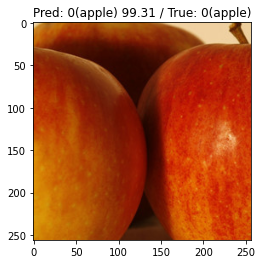

Predicted probability:
[0.99330616 0.00669384]


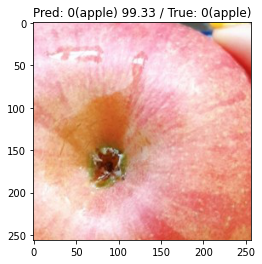

 False predicted images/total apple category: 0 / 13
Category: melon
 True predicted images/total melon category: 8 / 11
Predicted probability:
[2.6253590e-04 9.9973744e-01]


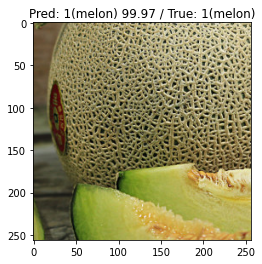

Predicted probability:
[2.5896847e-04 9.9974102e-01]


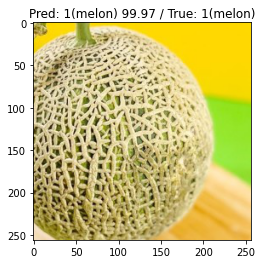

 False predicted images/total melon category: 3 / 11
Predicted probability:
[0.69183546 0.3081645 ]


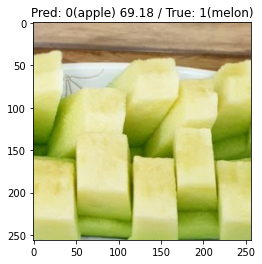

Predicted probability:
[0.74041396 0.25958604]


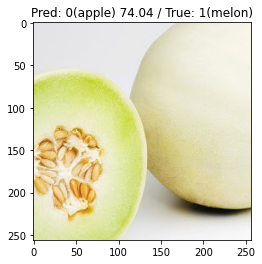

In [20]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n=2)